In [ ]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Load your own dataset
dataset = load_dataset("jubba/camouflaged_animals", split="train")  # Example dataset, replace with your dataset


# Create a subset of the first 1024 images
dataset = dataset.select(range(386))

# Check the length of the subset
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Modify the transform function to use cached 'pixel_values'
def transform(examples):
    # Check if 'pixel_values' is already present
    if "pixel_values" not in examples:
        examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        # Get the actual batch size
        current_batch_size = batch.shape[0]

        clean_images = batch.to("cuda")  # Move batch to GPU
        noise = torch.randn(clean_images.shape).to("cuda")

        # Generate timesteps with the correct batch size
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (current_batch_size,), device="cuda"
        ).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")
# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/387 [00:00<?, ?it/s]

Length of the subset: 386
Epoch 0, Step 0: Loss = 1.1514019966125488
Epoch 1, Step 0: Loss = 0.7121623754501343
Epoch 2, Step 0: Loss = 0.49592798948287964
Epoch 3, Step 0: Loss = 0.3428117632865906
Epoch 4, Step 0: Loss = 0.2794024646282196
Epoch 5, Step 0: Loss = 0.1577036827802658
Epoch 6, Step 0: Loss = 0.17444972693920135
Epoch 7, Step 0: Loss = 0.1709364503622055
Epoch 8, Step 0: Loss = 0.12055365741252899
Epoch 9, Step 0: Loss = 0.17501895129680634


Length of the dataset: 386


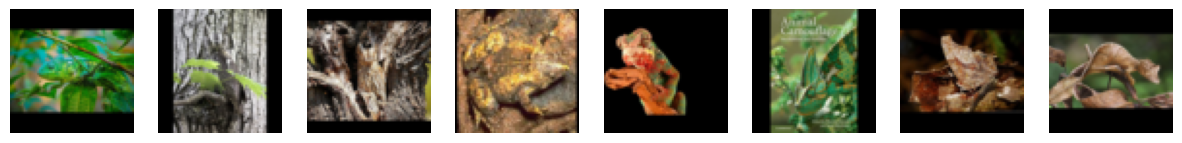

In [ ]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=8)

## Generate images from the trained model

<ipython-input-8-723cdbc28ba1>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animal_diffusion_model.pth"))


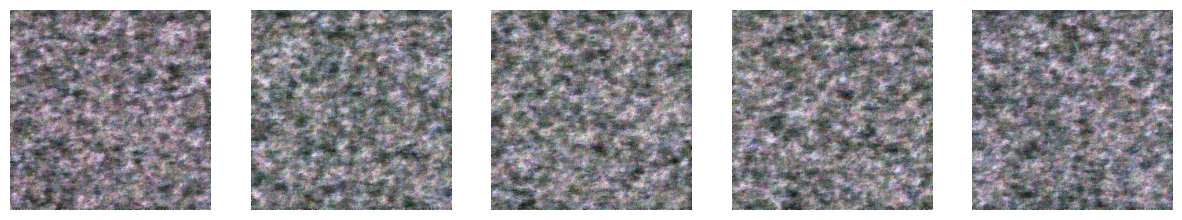

In [ ]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=600)

# Function to generate images
def generate_images(num_images=1, noise_level=0.8):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 256, 256)).to("cuda")  # Match input dimensions
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 5
generated_images = generate_images(num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

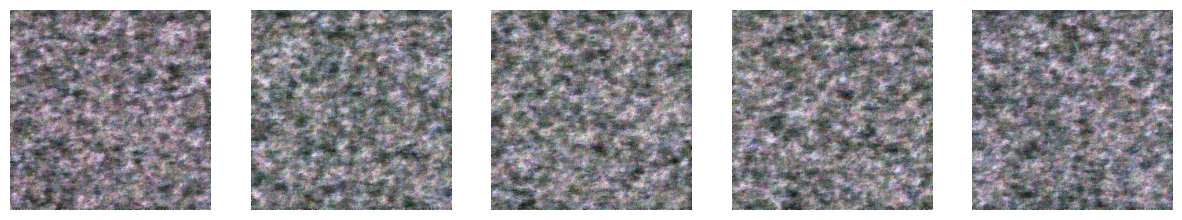

In [ ]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [ ]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'

In [ ]:
# prompt: Use a pre-trained transformer model GPT-2 to generate fictional text in an “animal language.”
# Define a structured prompt to guide the output.
# Create 16 animal sound effects that would sound like a language, make them not have any words in any dictionaries

from transformers import pipeline, set_seed

# Define animal sound effects (replace with your own creative sounds)
animal_sounds = [
    "grrr-zzz-whirr", "twit-fleep-bloop", "croak-quack-honk", "hiss-spat-chitter",
    "roar-snarl-grumble", "chirp-tweet-whistle", "howl-yelp-whine", "screech-squawk-caw",
    "rumble-thump-echo", "squeal-grunt-oink", "baa-bleat-meow", "clatter-click-tap",
    "whoosh-flutter-zoom", "splash-gurgle-drip", "rustle-crinkle-crackle", "hum-buzz-whirl"
]


# Create a structured prompt
prompt = """
Imagine a fictional language spoken by animals.  The language consists primarily of these sounds: {}.

Tell a short story of a brave fox who outsmarts a cunning wolf in this language.
""".format(", ".join(animal_sounds))


# Use GPT-2 to generate text (replace with the model you wish to use)
generator = pipeline('text-generation', model='gpt2')
set_seed(42) # for reproducibility
generated_text = generator(prompt, max_length=500, num_return_sequences=1)

# Print the generated text
print(generated_text[0]['generated_text'])


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Imagine a fictional language spoken by animals.  The language consists primarily of these sounds: grrr-zzz-whirr, twit-fleep-bloop, croak-quack-honk, hiss-spat-chitter, roar-snarl-grumble, chirp-tweet-whistle, howl-yelp-whine, screech-squawk-caw, rumble-thump-echo, squeal-grunt-oink, baa-bleat-meow, clatter-click-tap, whoosh-flutter-zoom, splash-gurgle-drip, rustle-crinkle-crackle, hum-buzz-whirl.

Tell a short story of a brave fox who outsmarts a cunning wolf in this language.

Examples of similar words

In English, words such as, eunuchs, sabbatical, pines (a family event), and furs always involve either a noun or an adjective.

Examples of non-English words

Feminine expressions

Erotic, idiomatic, and sometimes racist symbols

The following non-English words could be used in a given context.

Feminine pronouns

Feminine or masculinized pronouns

Female or feminineized pronouns

A more masculine form?

If you have not heard of a girl, your pronouns should be masculine - you don't n

In [ ]:
# prompt: Create an html that displays images from "Images" folder, sounds from "Sounds" folder and animal_sounds = [
#     "grrr-zzz-whirr", "twit-fleep-bloop", "croak-quack-honk", "hiss-spat-chitter",
#     "roar-snarl-grumble", "chirp-tweet-whistle", "howl-yelp-whine", "screech-squawk-caw",
#     "rumble-thump-echo", "squeal-grunt-oink", "baa-bleat-meow", "clatter-click-tap",
#     "whoosh-flutter-zoom", "splash-gurgle-drip", "rustle-crinkle-crackle", "hum-buzz-whirl"
# ]
# I want one random image to come up with, one random sound and one random text animal sound, then cycle through all of these every 3 seconds. The image names are: animal_00.png, animal_01.png, animal_02.png. animal_03.png, animal_04.png and the sounds are: animal_sound_1.wav, animal_sound_2.wav, animal_sound_3.wav, animal_sound_4.wav

<!DOCTYPE html>
<html>
<head>
<title>Animal Display</title>
<style>
  body {
    font-family: sans-serif;
    display: flex;
    flex-direction: column;
    align-items: center;
    justify-content: center;
    height: 100vh;
    margin: 0;
  }

  #image-container {
    width: 300px; /* Adjust image width as needed */
    height: 300px; /* Adjust image height as needed */
    overflow: hidden; /* Hide overflowing parts of images */
    margin-bottom: 20px;
  }
  #image-container img {
    width: 100%;
    height: 100%;
    object-fit: contain; /* Maintain aspect ratio and fit within container */
  }

  #sound-container {
    margin-bottom: 20px;
  }

  #text-container{
      margin-bottom: 20px;
  }

</style>
</head>
<body>

  <div id="image-container">
    <img id="animal-image" src="" alt="Animal Image">
  </div>

  <div id="sound-container">
    <audio id="animal-sound" controls></audio>
  </div>

  <div id="text-container">
      <p id="animal-text"></p>
  </div>

<script>
  const imageContainer = document.getElementById('image-container');
  const animalImage = document.getElementById('animal-image');
  const animalSound = document.getElementById('animal-sound');
  const animalText = document.getElementById('animal-text');
  const images = ["animal_00.png", "animal_01.png", "animal_02.png", "animal_03.png", "animal_04.png"];
  const sounds = ["animal_sound_1.wav", "animal_sound_2.wav", "animal_sound_3.wav", "animal_sound_4.wav"];
  const animalSoundsText = [
    "grrr-zzz-whirr", "twit-fleep-bloop", "croak-quack-honk", "hiss-spat-chitter",
    "roar-snarl-grumble", "chirp-tweet-whistle", "howl-yelp-whine", "screech-squawk-caw",
    "rumble-thump-echo", "squeal-grunt-oink", "baa-bleat-meow", "clatter-click-tap",
    "whoosh-flutter-zoom", "splash-gurgle-drip", "rustle-crinkle-crackle", "hum-buzz-whirl"
  ];


  function getRandomElement(arr) {
    return arr[Math.floor(Math.random() * arr.length)];
  }

  function updateContent() {
    const randomImage = getRandomElement(images);
    const randomSound = getRandomElement(sounds);
    const randomText = getRandomElement(animalSoundsText);

    animalImage.src = "images/" + randomImage;
    animalSound.src = "Sounds/" + randomSound;
    animalText.textContent = randomText;
    animalSound.play();
  }

  // Initial update
  updateContent();

  // Update every 3 seconds (3000 milliseconds)
  setInterval(updateContent, 3000);
</script>

</body>
</html>
